## Identifying putative synthetic lethal pairs using DepMap CRISPR screens

**Input:**
- gene scores processed with CERES
- gene expression and gene mutations from the DepMap portal (20Q2)
- processed homozygous deletions + cell lines that had copy number data
- annotated paralogs pairs from Ensembl
- cell line lineage annotations from DepMap
- protein atlas annotations of tissue distribution + specificity

**Output:** 
- putative (non-) synthetic lethal paralog pairs (bronze standard set)
- Table S3: binary matrix to indicate A2 loss in each of 762 cell lines
- Table S4: full results of testing candidate paralog pairs for association between A1 dependency and A2 loss

Method: compare A1 dependency where its paralog A2 is/is not lost, using multiple regression with cell line lineage covariate.

A2 lost:
- gene expression < 1 log(TPM)
- gene expression z-score < -4
- LOF mutation
- homozygous deletion supported by change in expression

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.formula.api as smf
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 1
%aimport graphing_params

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_gene_scores = get_local_data_path(['processed', 'depmap20Q2'], 'gene_scores_26_05_20.csv')
file_expression = get_data_path(['depmap', '20Q2'], 'CCLE_expression.csv')
file_mutations = get_data_path(['depmap', '20Q2'], 'CCLE_mutations.csv')
file_cell_lines_w_cn = get_local_data_path(['processed', 'depmap20Q2'], 'ccle_gene_cn_cell_lines.csv')
file_ccle_homdels = get_local_data_path(['processed', 'depmap20Q2'], 'ccle_homdels_w_confidence.csv')
file_all_pairs = get_local_data_path(['processed', 'ensembl93'], 'all_pairs.csv')
file_protein_atlas = get_data_path(['protein_atlas'], 'proteinatlas_v19.3.tsv')
file_lineage = get_data_path(['depmap', '20Q2'], 'sample_info.csv')
file_validate_SLs = get_local_data_path([], 'validated_SLs.txt')

# Outputs
file_A2_lost = get_local_data_path(['results'], 'A2_gene_loss_24_09_20.csv')
file_bronze_standard = get_local_data_path(['results'], 'bronze_standard_SL_pairs_24_09_20.csv')
file_full_tested_pairs = get_local_data_path(['results'], 'full_SL_pairs_results_24_09_20.csv')
file_table_s3 = get_local_data_path(['supplemental_files'], 'Table_S3.csv')
file_table_s4 = get_local_data_path(['supplemental_files'], 'Table_S4.csv')

### Data sources

#### CERES gene scores

In [3]:
all_scores = pd.read_csv(file_gene_scores, index_col=0)

In [4]:
print(all_scores.shape)
all_scores[:1]

(769, 16445)


,1,29974,2,144568,127550,53947,51146,8086,65985,13,...,221302,9183,55055,11130,79364,440590,79699,7791,23140,26009
ACH-001382,0.652347,-0.020793,-0.270112,-0.211408,0.06271,-0.081674,0.37684,-0.767385,0.166991,0.112045,...,0.182055,-0.724872,0.499652,-0.141164,-0.336501,0.250665,-0.676302,-0.098001,-0.677497,-0.506629


#### Gene Expression

In [5]:
all_expr_raw = pd.read_csv(file_expression, index_col=0, sep='\t')

In [6]:
get_gene_id = lambda x: re.search('[\w-]+\s\((\w+)\)', x).group(1)
all_expr = all_expr_raw.rename(columns=get_gene_id)
all_expr[:1]

,7105,64102,8813,57147,55732,2268,3075,2519,2729,4800,...,112441429,112441438,341568,112441431,729759,110599564,6905,112577462,89839,112577461
ACH-001097,0.0,0.0,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,2.15056,...,0.0,0.0,0.0,0.0,0.0,2.980025,5.132988,0.0,0.443607,0.0


In [7]:
all_expr_zscored = all_expr.apply(lambda x: stats.zscore(x) if not (x==0).all() else 0)
all_expr_zscored[:1]

,7105,64102,8813,57147,55732,2268,3075,2519,2729,4800,...,112441429,112441438,341568,112441431,729759,110599564,6905,112577462,89839,112577461
ACH-001097,-2.098497,-0.198894,-2.659021,-1.111848,-0.22196,3.173235,-0.68515,-1.59882,-2.367321,-3.015304,...,-0.027703,0,-0.167573,-0.052889,-0.452706,-0.305474,0.598535,-0.1728,-1.805753,-0.498198


In [8]:
print('Overlapping cell lines fitness/expr:', all_expr[all_expr.index.isin(all_scores.index)].shape[0],'/',all_scores.shape[0])

Overlapping cell lines fitness/expr: 763 / 769


#### Mutations

In [9]:
all_mutations_raw = pd.read_csv(file_mutations, low_memory=False, sep='\t')

In [10]:
all_mutations_raw[:1]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,ExAC_AF,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID
0,A1BG,1,37,19,58858743,58858743,+,Missense_Mutation,SNP,C,...,NaN,NaN,20:16,20:16,NaN,NaN,NaN,NaN,other non-conserving,ACH-000986


In [11]:
all_mutations = all_mutations_raw.rename(columns={'Entrez_Gene_Id':'entrez_id','DepMap_ID':'cell_line', 'Hugo_Symbol':'symbol'})
all_mutations = all_mutations[['entrez_id', 'symbol', 'Variant_Classification', 'cell_line', 'isDeleterious']]
all_mutations = all_mutations.astype({'entrez_id':'str'})
print('Overlapping cell lines:', all_mutations[all_mutations.cell_line.isin(all_scores.index)].cell_line.nunique(), 
      '/', all_scores.shape[0])

# Mutation types to consider
lof_mutations = ['Splice_Site', 'Nonsense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins', 'De_novo_Start_OutOfFrame']
mutations = all_mutations[all_mutations.Variant_Classification.isin(lof_mutations)]

print('Any not annotated as deleterious?', mutations[mutations.isDeleterious==False].shape[0])
display(mutations.Variant_Classification.value_counts())
mutations[:1]

Overlapping cell lines: 767 / 769
Any not annotated as deleterious? 0


Splice_Site                 43468
Frame_Shift_Del             42362
Nonsense_Mutation           40796
Frame_Shift_Ins             24744
De_novo_Start_OutOfFrame     4565
Name: Variant_Classification, dtype: int64

,entrez_id,symbol,Variant_Classification,cell_line,isDeleterious
32,1,A1BG,Nonsense_Mutation,ACH-000983,True


#### Homozygous deletions

In [12]:
# Get copy number data to compute overlapping cell lines
copy_num_cell_lines = pd.read_csv(file_cell_lines_w_cn)
copy_num_cell_lines[:1]

,cell_line
0,ACH-000001


In [13]:
all_ccle_homdels = pd.read_csv(file_ccle_homdels)
all_ccle_homdels = all_ccle_homdels.rename(columns={'depMapID':'cell_line'}).astype({'entrez_id':'str'})
print('Overlap with score cell lines:', all_scores.loc[all_scores.index.isin(all_ccle_homdels.cell_line),:].shape[0], '/',
      all_scores.shape[0])

# Restrict to confident homdels aka homdels supported by change in expression
ccle_homdels = all_ccle_homdels[all_ccle_homdels.confident].reset_index()
print('Genes with confident HDs:', ccle_homdels.entrez_id.nunique())
ccle_homdels[:1]

Overlap with score cell lines: 768 / 769
Genes with confident HDs: 3131


,index,entrez_id,pval,tstat,del_expr,other_expr,num_homdels,confident,cell_line
0,32,1000,0.006649,-2.718353,1.862278,3.064374,36,True,ACH-000109


#### Paralog pairs

In [14]:
# Load all paralog pairs from Ensembl
all_pairs = pd.read_csv(file_all_pairs)
all_pairs = all_pairs.astype({'A1_entrez':'str', 'A2_entrez':'str'})
print('Protein coding paralog pairs from Ensembl:', int(all_pairs.shape[0]))
print('Protein coding pairs min. 20% (reciprocal)', int(all_pairs[all_pairs.min_seq_id>=0.2].shape[0]))
all_pairs[:1]

Protein coding paralog pairs from Ensembl: 73296
Protein coding pairs min. 20% (reciprocal) 56870


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,cds_length_ratio,A1,A1_entrez,A2,A2_entrez
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False,5,0.988532,TEKT2,27285,TEKT4,150483


In [15]:
pd.concat([all_pairs.A1, all_pairs.A2]).unique()[:2000]

array(['TEKT2', 'TEKT1', 'TEKT5', ..., 'CLCNKB', 'CLCN1', 'CLCN7'],
      dtype=object)

#### Protein atlas tissue specificity + distribution

In [16]:
protein_atlas_all = pd.read_csv(file_protein_atlas, sep='\t')

In [17]:
protein_atlas = protein_atlas_all[['Ensembl', 'Gene', 'RNA tissue specificity', 'RNA tissue distribution']]
print('Pairs in atlas:', all_pairs[all_pairs.A1_ensembl.isin(protein_atlas.Ensembl) & 
                                   all_pairs.A2_ensembl.isin(protein_atlas.Ensembl)].shape[0], '/', all_pairs.shape[0])

Pairs in atlas: 73296 / 73296


#### Cell line lineage

In [18]:
cell_line_lineage = pd.read_csv(file_lineage)
cell_line_lineage = cell_line_lineage[['DepMap_ID', 'lineage']].rename(columns={'DepMap_ID':'cell_line'})
print(cell_line_lineage[cell_line_lineage.cell_line.isin(all_scores.index)].shape[0], '/', all_scores.shape[0])
cell_line_lineage[:2]

769 / 769


,cell_line,lineage
0,ACH-000001,ovary
1,ACH-000002,blood


Text(0.5, 0, 'Count')

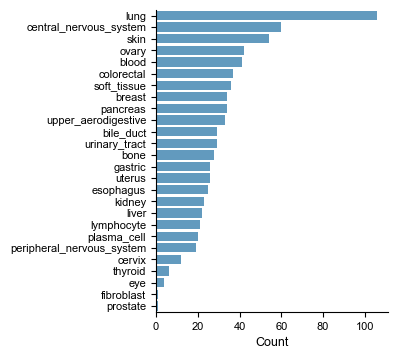

In [19]:
f, ax = plt.subplots(1, 1, figsize=(3,4))
sns.barplot(x='lineage', y='index', ax=ax, color=sns.color_palette('Blues')[3],
            data=cell_line_lineage[cell_line_lineage.cell_line.isin(all_scores.index)].lineage.value_counts().reset_index())
ax.set_ylabel(''); ax.set_xlabel('Count')

### Derive candidate paralog pairs

- Min seq id >= 20%
- Family size <= 20
- A1 and A2 are broadly expressed:
    - RNA tissue distribution = 'Detected in all' OR
    - RNA tissue distribution = 'Detected in many' AND RNA tissue specificity = Low specificity', 'Not detected'
- A1 is in CERES scores data frame
- A2 lost in min. 10 (max 90%) cell lines

In [20]:
# Use scores for cell lines that were included in expr + mutation + copy number data sets
scores = all_scores.loc[all_scores.index.isin(all_expr.index) & all_scores.index.isin(all_mutations.cell_line) &
                        all_scores.index.isin(copy_num_cell_lines.cell_line), :]
print('Cell lines to use:', scores.shape[0], '/', all_scores.shape[0])

Cell lines to use: 762 / 769


In [21]:
# Filter for genes that are broadly expressed (not tissue specific)
protein_atlas_filter = protein_atlas[protein_atlas['RNA tissue distribution'].isin(['Detected in all']) |
                                     (protein_atlas['RNA tissue distribution'].isin(['Detected in many']) &
                                      protein_atlas['RNA tissue specificity'].isin(['Low tissue specificity','Not detected']))]

pairs_to_test = all_pairs[(all_pairs.min_seq_id >= 0.2) & (all_pairs.family_size <= 20) &
                          all_pairs.A1_entrez.isin(scores.columns) &
                          all_pairs.A1_ensembl.isin(protein_atlas_filter.Ensembl) &
                          all_pairs.A2_ensembl.isin(protein_atlas_filter.Ensembl)].reset_index(drop=True)

print('Num pairs to test after first filtering applied:', pairs_to_test.shape[0], '-- unique:',
      pd.DataFrame(np.sort(pairs_to_test[['A1','A2']])).drop_duplicates().shape[0])
print('Num A2s in this list:', pairs_to_test.A2.nunique())
pairs_to_test[:1]

Num pairs to test after first filtering applied: 9638 -- unique: 5271
Num A2s in this list: 4468


,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,cds_length_ratio,A1,A1_entrez,A2,A2_entrez
0,ENSG00000013503,ENSG00000047315,0.394528,0.38075,0.394528,False,False,False,False,True,2,0.965106,POLR3B,55703,POLR2B,5431


#### Call A2 gene loss
Output is saved, so no need to re-run

In [23]:
# Compute gene loss for an individual gene, cell lines should be a Series, gene_id = entrez id
def call_gene_loss(gene_id, cell_lines):
    A2_expr = all_expr.loc[:, gene_id]
    A2_expr_z = all_expr_zscored.loc[:, gene_id]
    results = pd.Series(cell_lines.isin(mutations[mutations.entrez_id==gene_id].cell_line) | 
                        cell_lines.isin(ccle_homdels[ccle_homdels.entrez_id==gene_id].cell_line) |
                        cell_lines.isin(A2_expr[A2_expr < 1].index) |
                        cell_lines.isin(A2_expr_z[A2_expr_z < -4].index))
    results.index = list(cell_lines)
    return results

# Only consider the 762 cell lines for which there is data from all 4 sources
cell_lines = pd.Series(sorted(scores.index.values))

# Compute loss (T/F) across all cell lines for all unique A2 genes in the candidate pairs
unique_A2s = pairs_to_test[['A2_entrez']].drop_duplicates().A2_entrez
A2_lost_df = unique_A2s.apply(call_gene_loss, args=(cell_lines,))
A2_lost_df.index = unique_A2s.values

In [67]:
assert(A2_lost_df.shape[1] == scores.shape[0])
assert(A2_lost_df.shape[0] == pairs_to_test.A2.nunique())
A2_lost_df.to_csv(file_A2_lost)
A2_lost_df[:1]

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001960,ACH-001997,ACH-001999,ACH-002001,ACH-002002,ACH-002003,ACH-002004,ACH-002005,ACH-002015,ACH-002016
5431,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
# Create summary table from A2 lost dataframe
A2_lost = A2_lost_df.sum(axis=1).reset_index().rename(columns={'index':'A2_entrez', 0:'n_A2_lost'})
A2_lost = pd.merge(pairs_to_test[['A2','A2_entrez']], A2_lost)
display(A2_lost[:1])

,A2,A2_entrez,n_A2_lost
0,POLR2B,5431,18


In [30]:
# Only test pairs where A2 is lost in min. 10 and max 90% of cell lines
A2_lost_filter = A2_lost[(A2_lost.n_A2_lost >= 10) & (A2_lost.n_A2_lost <= (scores.shape[0]*0.9))]
pairs_to_test_2 = pairs_to_test[pairs_to_test.A2_entrez.isin(A2_lost_filter.A2_entrez)].reset_index(drop=True)

print('Num pairs to test after second filtering applied:', pairs_to_test_2.shape[0], '-- unique:', 
      pd.DataFrame(np.sort(pairs_to_test_2[['A1','A2']]), columns=['A1', 'A2']).drop_duplicates().shape[0])

Num pairs to test after second filtering applied: 5209 -- unique: 3813


In [31]:
# Save A2 lost dataframe, for just the final candidate pairs, as a binary matrix for table S3
tab_s3 = A2_lost_df[A2_lost_df.index.isin(pairs_to_test_2.A2_entrez)].astype(int)
print('N. unique A2s:', tab_s3.shape[0])
assert(tab_s3.shape[0] == pairs_to_test_2.A2_entrez.nunique())
display(tab_s3[:1])
tab_s3.to_csv(file_table_s3)

N. unique A2s: 2333


,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001960,ACH-001997,ACH-001999,ACH-002001,ACH-002002,ACH-002003,ACH-002004,ACH-002005,ACH-002015,ACH-002016
5431,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Compare A1 CERES score for A2 WT vs. A2 ALT
Using a linear model with cell line lineage as a covariate

In [32]:
# Test whether there is a significant difference in fitness score of A1 when A2 is/is not lost
def test_A1_score_for_A2_loss_vs_wt(pair):
    # A1 score for each cell line
    A1_scores = scores.loc[:, pair.A1_entrez].reset_index().rename(columns={'index':'cell_line', pair.A1_entrez:'A1_score'})
    # A2 lost (T/F) for each cell line
    A2_info = A2_lost_df.loc[pair.A2_entrez,:].reset_index().rename(columns={'index':'cell_line', pair.A2_entrez:'A2_lost'})
    # Merge score, loss status, cell line lineage
    df = pd.merge(pd.merge(A1_scores, A2_info), cell_line_lineage).dropna(subset=['A1_score'])
    # Linear model
    ols_results = smf.ols('A1_score ~ C(lineage) + C(A2_lost)', data=df).fit()
    ols_pval = ols_results.pvalues['C(A2_lost)[T.True]']
    ols_coef = ols_results.params['C(A2_lost)[T.True]']
    return pd.Series([pair.A1, pair.A2, ols_pval, ols_coef, df[df.A2_lost].shape[0], 
                      df[df.A2_lost].A1_score.mean(), df[~df.A2_lost].A1_score.mean()], 
                      index=['A1', 'A2', 'ols_p', 'ols_coef', 'n_A2_lost', 'A2_lost_mean_score', 'A2_other_mean_score'])

In [33]:
raw_results = pairs_to_test_2.apply(test_A1_score_for_A2_loss_vs_wt, axis=1)

Text(0.5, 0, 'A2 lost p-value')

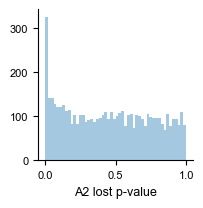

In [34]:
# Plot distribution of p-values
f, ax = plt.subplots(1, 1, figsize=(2,2), sharey=True)
sns.distplot(raw_results.ols_p, kde=False, ax=ax, bins=50)
ax.set_xlabel('A2 lost p-value')

### Process Raw Results
Benjamini-Hochberg multiple testing correction

In [35]:
# Compute percent of cell lines in which each gene is essential
percent_essential = ((scores < -0.6).sum()/scores.shape[0])
percent_essential = percent_essential.reset_index().rename(columns={'index':'A1_entrez',0:'percent_essential'})
percent_essential[:1]

,A1_entrez,percent_essential
0,1,0.0


In [36]:
def process_results(raw_results):
    
    # Merge percent of cell lines in which A1 is essential
    df = pd.merge(raw_results, pairs_to_test[['A1', 'A2', 'A1_entrez', 'A2_entrez']])
    df = pd.merge(df, percent_essential)
    print('N sometimes essential:', df[df.percent_essential>0].shape[0])
    
    # FDR correction for pairs that are essential in at least 1 cell line
    results = df[df.percent_essential>0].reset_index(drop=True)
    results = results.assign(p_adj = fdrcorrection(results.ols_p.values)[1])
    
    # SL if FDR < 10% + A2_lost coefficient is negative (associated with decrease in CERES score)
    results = results.assign(SL = results.apply(lambda x: ((x.p_adj < 0.1) & (x.ols_coef < 0)), axis=1))
    
    # Directly mark pairs that are never essential is not SL
    never_essential = df[df.percent_essential==0].reset_index(drop=True)
    results = pd.concat([results, never_essential]).reset_index(drop=True).fillna({'SL':False})
    
    # Annotate nearly SLs that will be dropped: nominal p-value < 0.05
    results = results.assign(nearly_SL = ((results.ols_p < 0.05) & (results.ols_coef < 0) & 
                                          (results.percent_essential > 0) & (results.SL==False)))   
    return results

In [37]:
results = process_results(raw_results)
results[:2]

N sometimes essential: 3735


,A1,A2,ols_p,ols_coef,n_A2_lost,A2_lost_mean_score,A2_other_mean_score,A1_entrez,A2_entrez,percent_essential,p_adj,SL,nearly_SL
0,POLR3B,POLR2B,0.009881,0.156941,18,-1.395492,-1.513881,55703,5431,0.998688,0.171498,False,False
1,ID3,ID2,0.835119,0.007488,24,-0.017086,-0.019212,3399,3398,0.006562,0.969890,False,False


In [63]:
# Check how many potential SL pairs there are, and whether they include previously validated SL pairs
validated_SLs = pd.read_csv(file_validate_SLs)
print('N. previously validated SL paralog pairs:', validated_SLs.shape[0])

def check_SLs(results):
    print('SL pairs: %d / %d --> %.2f%%' % (sum(results.SL), results.shape[0], (sum(results.SL) / results.shape[0])*100))
    # Sort pairs to get non-duplicated list
    df = pd.concat([pd.DataFrame(np.sort(results[['A1','A2']]), columns=['A1','A2']), results[['SL']]], axis=1)
    df = df.groupby(['A1', 'A2']).SL.max().reset_index()
    print('Unique pairs: %d / %d --> %.2f%%' % (sum(df.SL==True), df.shape[0], (sum(df.SL==True)/df.shape[0])*100))
    # Merge with known SLs (Nan if not tested)
    m1 = pd.merge(validated_SLs, df[['A1', 'A2', 'SL']], how='left')
    m2 = pd.merge(validated_SLs, df[['A1', 'A2', 'SL']].rename(columns={'A1':'A2', 'A2':'A1'}), how='left')
    overlap = pd.concat([m1, m2]).groupby(['A1', 'A2']).SL.max().reset_index()
    print('Known SLs retrieved:', sum(overlap.SL==True))
    for i, row in overlap.iterrows():
        if row.SL==True: continue
        if row.SL==False: print(row.A1,'-',row.A2, 'not SL')
        else: print(row.A1,'-',row.A2, 'not tested')

N. previously validated SL paralog pairs: 12


In [64]:
check_SLs(results)

SL pairs: 132 / 5209 --> 2.53%
Unique pairs: 127 / 3813 --> 3.33%
Known SLs retrieved: 7
DDX17 - DDX5 not SL
ENO1 - ENO2 not tested
MAGOH - MAGOHB not tested
ME2 - ME3 not SL
SMARCC1 - SMARCC2 not SL


In [45]:
results.to_csv(file_full_tested_pairs, index=0)

In [44]:
tab_s4 = results[['A1','A2','A1_entrez','A2_entrez', 'ols_coef', 'ols_p', 'p_adj', 'SL', 'nearly_SL']]
tab_s4 = tab_s4.rename(columns={'ols_coef':'A2_status_coef', 'ols_p':'A2_status_p', 'p_ajd':'A2_status_p_adj'})

# Set SL to NA if pair will be dropped, i.e. if it is nearly_SL
tab_s4.SL = tab_s4.apply(lambda x: float('nan') if x.nearly_SL else x.SL, axis=1)
# Add in ensembl ids
tab_s4 = pd.merge(all_pairs[['A1','A2','A1_ensembl','A2_ensembl']], tab_s4)
tab_s4 = tab_s4.sort_values(['A1','A2']).drop(columns=['nearly_SL'])

assert(tab_s4.shape[0] == results.shape[0])
assert(tab_s4[tab_s4.SL==True].shape[0] == results[results.SL==True].shape[0])
display(tab_s4[:3])
tab_s4.to_csv(file_table_s4)

,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,A2_status_coef,A2_status_p,p_adj,SL
5099,AAK1,BMP2K,ENSG00000115977,ENSG00000138756,22848,55589,-0.033343,0.445352,0.872559,False
3680,ABCA1,ABCA7,ENSG00000165029,ENSG00000064687,19,10347,-0.000272,0.992886,0.998337,False
3679,ABCA7,ABCA1,ENSG00000064687,ENSG00000165029,10347,19,-0.016974,0.147058,0.647219,False


### Bronze Standard Dataset
This is a subset of the full results - discard 'nearly SL' pairs and only retain unique pairs

In [46]:
# Can load here - so no need to re-run above code
results = pd.read_csv(file_full_tested_pairs).astype({'A1_entrez':'str','A2_entrez':'str'})
print('N:', results.shape[0])
results[:1]

N: 5209


,A1,A2,ols_p,ols_coef,n_A2_lost,A2_lost_mean_score,A2_other_mean_score,A1_entrez,A2_entrez,percent_essential,p_adj,SL,nearly_SL
0,POLR3B,POLR2B,0.009881,0.156941,18,-1.395492,-1.513881,55703,5431,0.998688,0.171498,False,False


In [58]:
# Reduce paralog pairs to sorted list of unique pairs
# Mark as SL if the pair is SL in either direction
def reduce_to_unique_pairs(results):
    # Sort A1, A2 to get unique pairs 
    sorted_pairs = pd.concat([pd.DataFrame(np.sort(results[['A1','A2']]), columns=['A1','A2']),
                              results[['SL', 'ols_p', 'p_adj', 'nearly_SL', 'n_A2_lost', 'percent_essential']]], axis=1)
    sorted_pairs = sorted_pairs.sort_values(['A1', 'A2'], ascending=True)
    assert(sorted_pairs.shape[0] == results.shape[0])
    
    # Find pairs that were tested in both directions
    duplicates = sorted_pairs[sorted_pairs.duplicated(subset=['A1','A2'], keep=False)]
    print('Num duplicate pairs:', int(duplicates.shape[0]/2))
    print('Assymetric SL:', int(duplicates[~duplicates.duplicated(subset=['A1','A2','SL'], keep=False)].shape[0]/2))
    print('Symmetric SLs:')
    print(sorted_pairs[sorted_pairs.SL & sorted_pairs.duplicated(subset=['A1','A2','SL'])][['A1','A2']])
    
    cols_agg = {'SL':'max', 'nearly_SL':'max'} 
    unique_pairs = sorted_pairs.groupby(['A1', 'A2']).agg(cols_agg).reset_index()
    assert(unique_pairs.shape[0] == (results.shape[0] - (duplicates.shape[0] / 2)))
    # Nearly SL was called assymetrically so resolve call
    unique_pairs.nearly_SL = unique_pairs.apply(lambda x: False if x.SL==True else x.nearly_SL, axis=1)
    print('Unique pairs: %d / %d' % (unique_pairs[unique_pairs.SL].shape[0], unique_pairs.shape[0]))
    return unique_pairs

def drop_nearly_SL_pairs(results):
    print('Num nearly SL:', results[results.nearly_SL].shape[0])
    # Drop nearly SL pairs
    final_results = results[results.nearly_SL==False].reset_index(drop=True).drop(columns=['nearly_SL'])
    print('Bronze standard pairs: %d / %d = %.2f%% SL' % (final_results[final_results.SL].shape[0], final_results.shape[0],
          final_results[final_results.SL].shape[0] / final_results.shape[0] *100))
    return final_results

In [68]:
unique_results = reduce_to_unique_pairs(results)
bronze_standard = drop_nearly_SL_pairs(unique_results)
# Merge back ensembl ids
bronze_standard = pd.merge(bronze_standard, all_pairs[['A1','A2','A1_ensembl','A2_ensembl','A1_entrez','A2_entrez']])
bronze_standard[:2]

Num duplicate pairs: 1396
Assymetric SL: 32
Symmetric SLs:
           A1       A2
3144   FERMT1   FERMT2
1323    MYH10     MYH9
1989  SLC16A1  SLC16A3
3706  SMARCA2  SMARCA4
1685    SNAI1    SNAI2
Unique pairs: 127 / 3813
Num nearly SL: 176
Bronze standard pairs: 127 / 3637 = 3.49% SL


,A1,A2,SL,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
0,AAK1,BMP2K,False,ENSG00000115977,ENSG00000138756,22848,55589
1,ABCA1,ABCA7,False,ENSG00000165029,ENSG00000064687,19,10347


In [69]:
check_SLs(bronze_standard)

SL pairs: 127 / 3637 --> 3.49%
Unique pairs: 127 / 3637 --> 3.49%
Known SLs retrieved: 7
DDX17 - DDX5 not SL
ENO1 - ENO2 not tested
MAGOH - MAGOHB not tested
ME2 - ME3 not SL
SMARCC1 - SMARCC2 not SL


In [70]:
bronze_standard.to_csv(file_bronze_standard, index=0)

### Visualization of Individual Bronze Standard Pairs
Requires scores + A2_lost df + full results

In [5]:
A2_lost_df = pd.read_csv(file_A2_lost, index_col=0)
A2_lost_df.index = A2_lost_df.index.astype('str')
A2_lost_df[:1]

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001960,ACH-001997,ACH-001999,ACH-002001,ACH-002002,ACH-002003,ACH-002004,ACH-002005,ACH-002015,ACH-002016
5431,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
scores = all_scores[all_scores.index.isin(A2_lost_df.columns)]

In [7]:
results = pd.read_csv(file_full_tested_pairs).astype({'A1_entrez':'str','A2_entrez':'str'})
results[:1]

,A1,A2,ols_p,ols_coef,n_A2_lost,A2_lost_mean_score,A2_other_mean_score,A1_entrez,A2_entrez,percent_essential,p_adj,SL,nearly_SL
0,POLR3B,POLR2B,0.009881,0.156941,18,-1.395492,-1.513881,55703,5431,0.998688,0.171498,False,False


In [13]:
def box_plot_for_pair(A1, A2, ax, show_points=True):
    pair = results.loc[(results.A1==A1) & (results.A2==A2),:].iloc[0]
    if pair.SL == False: print('Pair %s-%s is not SL' % (A1, A2))
    df = scores.loc[:, pair.A1_entrez].reset_index().rename(columns={'index':'cell_line', pair.A1_entrez:'A1_score'})
    A2_info = A2_lost_df.loc[pair.A2_entrez,:].reset_index().rename(columns={'index':'cell_line', pair.A2_entrez:'A2_lost'})
    df = pd.merge(df, A2_info)
    df.A2_lost = df.A2_lost.apply(lambda x: ('Loss' if x else 'WT'))
    df = df.sort_values('A2_lost', ascending=False)
    sns.boxplot(y='A1_score', x='A2_lost', data=df, palette=['white', "#56B4E9"], ax=ax, linewidth=1, 
                showfliers=False, showmeans=False, saturation=1, boxprops=dict(alpha=0.5), 
                medianprops=dict(linewidth=1.2, color='black'))
    if show_points:
        sns.stripplot(y='A1_score', x='A2_lost', data=df, color='grey', ax=ax, alpha=0.7, size=2, zorder=0)
        ax.set_xlabel(pair.A2, fontstyle='italic'); ax.set_ylabel('')
        y_mid = ((df.A1_score.max()+df.A1_score.min())/2) - ((len('dependency')-len(pair.A1))*0.02)
        ax.text(-1.5, y_mid, pair.A1+' ', rotation=90, verticalalignment='top', fontstyle='italic')
        ax.text(-1.5, y_mid, 'dependency', rotation=90, verticalalignment='bottom')

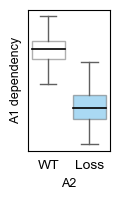

In [14]:
# Model of what we are testing
with plt.rc_context({'axes.spines.top': True, 'axes.spines.right':True, 'font.size':10,
                     'xtick.labelsize':10, 'xtick.bottom': False}):
    f, ax = plt.subplots(1, 1, figsize=(1.3,2.1))
    box_plot_for_pair('RPP25L', 'RPP25', ax, show_points=False)
    ax.set_xlabel('A2'); ax.set_ylabel('A1 dependency')
    ax.set_yticks([])
    plt.tight_layout()
    f.savefig('../figures/for_paper/boxplot_example.svg', bbox_inches='tight', dpi=300)

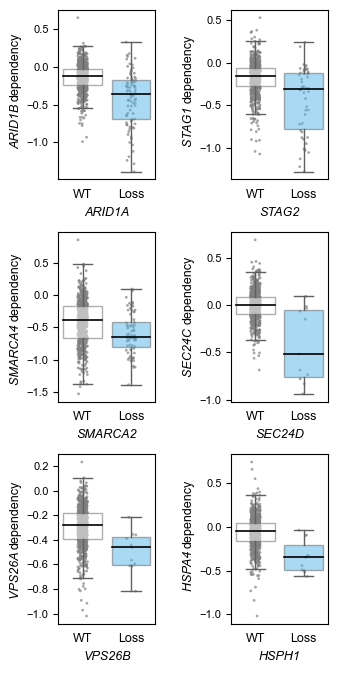

In [15]:
with mpl.rc_context({'axes.spines.top': True, 'axes.spines.right':True, 'ytick.labelsize':8, 'xtick.labelsize':9,
                     'xtick.bottom': False}):
    f, ax = plt.subplots(3, 2, figsize=(3.6,6.8))
    ax = ax.flatten()
    box_plot_for_pair('ARID1B', 'ARID1A', ax[0])
    box_plot_for_pair('STAG1', 'STAG2', ax[1])
    box_plot_for_pair('SMARCA4', 'SMARCA2', ax[2])
    box_plot_for_pair('SEC24C', 'SEC24D', ax[3])
    box_plot_for_pair('VPS26A', 'VPS26B', ax[4])
    box_plot_for_pair('HSPA4', 'HSPH1', ax[5])
    plt.tight_layout(w_pad=1)
    f.savefig('../figures/for_paper/boxplot_example_SLs.svg', bbox_inches='tight', dpi=300)

### Pairs not tested in previous computational analyses

In [77]:
file_hart_comp_pairs = get_data_path(['GI_screens', 'dede_2020'], 'Table_S1.xls')
file_hahn_pairs1 = get_data_path(['viswanathan_2018'], 'Table_S1_paralog_dep_shrna.csv')
file_hahn_pairs2 = get_data_path(['viswanathan_2018'], 'Table_S2_paralog_dep_crispr.csv')

In [78]:
def get_pairs_not_in_bronze_standard(other_pairs):
    df = pd.concat([pd.merge(bronze_standard, other_pairs),
                    pd.merge(bronze_standard, other_pairs.rename(columns={'A1':'A2','A2':'A1'}))
                   ])
    df = pd.merge(bronze_standard, df.drop_duplicates(), how='left', indicator='overlap')
    not_overlap = df[df.overlap=='left_only'].drop(columns=['overlap'])
    return not_overlap

In [80]:
hart_pairs = pd.read_excel(file_hart_comp_pairs)
n_hart = get_pairs_not_in_bronze_standard(hart_pairs.rename(columns={'Gene_A':'A1','Gene_B':'A2'})[['A1','A2']])
n_hart[:1]

,A1,A2,SL,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
1,ABCA1,ABCA7,False,ENSG00000165029,ENSG00000064687,19,10347


In [82]:
hahn_pairs_shrna = pd.read_csv(file_hahn_pairs1)
hahn_pairs_crispr = pd.read_csv(file_hahn_pairs2)
n_hahn_1 = get_pairs_not_in_bronze_standard(hahn_pairs_shrna.rename(columns={'Dep_Gene':'A1','Loss_Gene':'A2'})[['A1','A2']])
n_hahn_2 = get_pairs_not_in_bronze_standard(hahn_pairs_crispr.rename(columns={'Dep_Gene':'A1','Loss_Gene':'A2'})[['A1','A2']])
n_hahn = pd.merge(n_hahn_1, n_hahn_2)
n_hahn[:1]

,A1,A2,SL,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
0,AAK1,BMP2K,False,ENSG00000115977,ENSG00000138756,22848,55589


In [83]:
# SL pairs that were not previously tested in a computational analysis
not_tested = pd.merge(n_hart, n_hahn)
not_tested = pd.concat([pd.merge(not_tested[not_tested.SL][['A1','A2']], results),
                        pd.merge(not_tested[not_tested.SL][['A1','A2']].rename(columns={'A1':'A2','A2':'A1'}), results)])
not_tested[['A1','A2','ols_p','ols_coef','p_adj','SL']].sort_values('ols_coef')[:10]

,A1,A2,ols_p,ols_coef,p_adj,SL
17,SEC24C,SEC24D,5.021426e-16,-0.415167,1.103237e-13,True
9,HSPA4,HSPH1,4.175154e-06,-0.271964,2.942302e-04,True
3,DIAPH1,INF2,5.238246e-04,-0.219949,2.081367e-02,True
10,LDHA,LDHB,2.629650e-05,-0.199090,1.693404e-03,True
20,VPS26A,VPS26B,1.095842e-04,-0.188909,5.385487e-03,True
10,TLE4,TLE3,3.797281e-05,-0.168721,2.325056e-03,True
11,ZNF746,ZNF398,4.343418e-05,-0.167133,2.575026e-03,True
9,UBP1,TFCP2,1.918005e-09,-0.161803,2.310887e-07,True
6,EXOC6,EXOC6B,8.386245e-09,-0.160700,9.212537e-07,True
5,ORAI3,ORAI2,5.467065e-04,-0.160258,2.105102e-02,True
